<a href="https://colab.research.google.com/github/connorj4/serial-multibiometric-face-fingerprint/blob/master/Improved_Siamese_networks_for_one_shot_finger_biometrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [0]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [156]:
class Config():
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    training_dir = "./gdrive/My Drive/fingerprint/train/"
    testing_dir = "./gdrive/My Drive/fingerprint/test/"
    #train_batch_size = 64
    train_batch_size = 64
    train_number_epochs = 1000
from PIL import Image
img = Image.open('./gdrive/My Drive/fingerprint/train/1/1.jpg')
print(img.size)

Mounted at /content/gdrive
(100, 100)


Exception ignored in: <bound method Image.__del__ of <PIL.JpegImagePlugin.JpegImageFile image mode=L size=100x100 at 0x7F36814CD898>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/PIL/Image.py", line 587, in __del__
    self.fp.close()
OSError: [Errno 107] Transport endpoint is not connected


In [157]:
!ls "./gdrive/My Drive/fingerprint/train/1/"

1.jpg	 l21.jpg  l33.jpg  l42.jpg  r15.jpg  r27.jpg  r39.jpg  r9.jpg
l12.jpg  l24.jpg  l36.jpg  l6.jpg   r18.jpg  r30.jpg  r3.jpg
l15.jpg  l27.jpg  l39.jpg  l9.jpg   r21.jpg  r33.jpg  r42.jpg
l18.jpg  l30.jpg  l3.jpg   r12.jpg  r24.jpg  r36.jpg  r6.jpg


In [0]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [0]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [160]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)
print(f'size of data {len(siamese_dataset)}')

size of data 1073


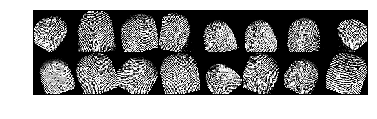

[[1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]]


In [161]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [0]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 64, kernel_size=8),
            nn.MaxPool2d(2,stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,stride=2),
            nn.BatchNorm2d(128),

            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,stride=2),
            nn.BatchNorm2d(256),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 512, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,stride=2),
            nn.BatchNorm2d(512),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(5*5*512, 800),
            nn.ReLU(inplace=True),

            nn.Linear(800, 1000),
            nn.ReLU(inplace=True),
            
            nn.Linear(1000, 800),
            nn.ReLU(inplace=True),

            nn.Linear(800, 40) #3
            #nn.Sigmoid(), #1.satruation, 2. useful info 
            )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [0]:
import numpy as np
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=4.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        #print(euclidean_distance)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)) #***
        if(loss_contrastive==1.0):
          print("bad margin")
        return loss_contrastive

In [0]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [0]:
net = SiameseNetwork().cuda()
sd = torch.load('/content/gdrive/My Drive/InfoSecFingerprint.pth')
net.load_state_dict(sd)
criterion = ContrastiveLoss()
#optimizer = optim.Adam(net.parameters(),lr = 0.0005 )
optimizer = optim.SGD(net.parameters(),lr = .0001,momentum = .9)

In [0]:
def save():
  import torch
  torch.save(net.state_dict(),'/content/gdrive/My Drive/InfoSecFingerprint.pth')

In [0]:
counter = []
loss_history = [] 
iteration_number= 0

In [168]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.5)
for epoch in range(0,20):
    total_loss = 0
    z=0
    for i, data in enumerate(train_dataloader,0):
        z+=1
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        #print(img0)
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        total_loss += loss_contrastive.item()
        optimizer.step()
    print(total_loss)
    scheduler.step()
        #if i % 10 == 9 :
        #    print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
        #    iteration_number +=10
        #    counter.append(iteration_number)
        #    loss_history.append(loss_contrastive.item())
            
        
#show_plot(counter,loss_history)
print("training completed")
print(f'total samples per minibatch {len(label)}')
print(f'total iterations per epoch: {z}')

69.19823837280273
69.54952955245972
69.12801766395569
69.3725438117981
69.10017132759094
69.18562436103821
69.0839900970459
69.18299150466919
69.241455078125
69.0711100101471
69.29670000076294
69.44494533538818
68.99129986763
69.24541091918945
69.68192768096924
69.11439323425293
69.40269088745117
68.48160219192505
69.10216426849365
68.9525580406189
training completed
total samples per minibatch 49
total iterations per epoch: 17


In [173]:
#folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
folder_dataset_test = dset.ImageFolder(root=Config.training_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
img0_tuple = folder_dataset.imgs[0]
print(img0_tuple[1])
img1_tuple = folder_dataset.imgs[1]
print(img1_tuple[1])
dataiter = iter(test_dataloader)
labels_test = []
similarity_score = []
for i in range(200):
  try:
    x0,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    #imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
    labels_test.append(label2.item())
    similarity_score.append(1-euclidean_distance.item())
  except:
    break;
print(labels_test)
print(similarity_score)
import numpy as np
similarity_score = (similarity_score - np.min(similarity_score))/np.ptp(similarity_score) # 0 to 1 norm.....
len(labels_test)
tuples =zip(similarity_score, labels_test)
from operator import itemgetter
tuples = sorted(tuples,key=itemgetter(0))
print(tuples)


0
0
[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 

In [170]:
'''correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total)) '''

"correct = 0\ntotal = 0\nwith torch.no_grad():\n    for data in test_dataloader:\n        images, labels = data\n        outputs = net(images)\n        _, predicted = torch.max(outputs.data, 1)\n        total += labels.size(0)\n        correct += (predicted == labels).sum().item()\n\nprint('Accuracy of the network on the 10000 test images: %d %%' % (\n    100 * correct / total)) "

In [0]:
save()

0.7209853976388455
0.5652939316707776
96
104
104
96
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (3, 17), (4, 17), (4, 18), (4, 19), (4, 20), (5, 20), (5, 21), (5, 22), (5, 23), (5, 24), (5, 25), (5, 26), (6, 26), (6, 27), (7, 27), (7, 28), (7, 29), (7, 30), (7, 31), (7, 32), (8, 32), (8, 33), (9, 33), (9, 34), (10, 34), (10, 35), (11, 35), (11, 36), (12, 36), (13, 36), (14, 36), (14, 37), (14, 38), (14, 39), (14, 40), (15, 40), (16, 40), (17, 40), (17, 41), (17, 42), (17, 43), (17, 44), (17, 45), (17, 46), (17, 47), (17, 48), (17, 49), (17, 50), (17, 51), (17, 52), (17, 53), (18, 53), (18, 54), (19, 54), (19, 55), (20, 55), (21, 55), (22, 55), (23, 55), (24, 55), (24, 56), (24, 57), (25, 57), (25, 58), (26, 58), (26, 59), (26, 60), (27, 60), (28, 60), (28, 61), (29, 61), (30, 61), (31, 61), (31, 62), (31, 63), (32, 63), (33, 63), (34, 63), (34, 64), (35, 64), (35, 65), 

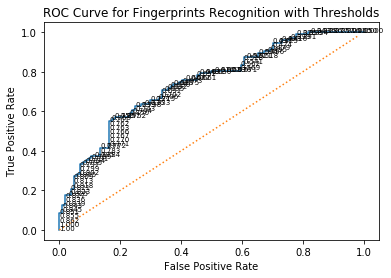

In [174]:
tuples =zip(similarity_score, labels_test)
avg0 = 0
avg1 = 0
num = 0
num1= 0
tuples_list = sorted(tuples)
for t in tuples_list:
  #print(t)
  if(t[1]==0.0):
    avg0 +=t[0]
    num+=1
  else:
    avg1 +=t[0]
    num1+=1
print(avg0/num)
print(avg1/num1)
print(num)
print(num1)
tuples_list.reverse()
datapoint = []
true_ = 0
false_ = 0
for t in tuples_list:
  if(t[1]==0.0):
    true_+=1
    datapoint.append((false_,true_))
  else:
    false_+=1
    datapoint.append((false_,true_))
import matplotlib.pyplot as plt
x = [0]
y = [0]
i=0
baseX = []
baseY = []
for i in range(0,16):
  baseX.append(i/15.0)
  baseY.append(i/15.0)
print(false_)
print(true_)
print(datapoint)
for pts in datapoint:
  x.append(pts[0]/false_)
  y.append(pts[1]/true_)
plt.plot(x,y)
xrand = list(range(0,99))
yrand = list(range(0,99))
for i in range(0,99):
  xrand[i] = xrand[i]/100
  yrand[i] = yrand[i]/100
plt.plot(xrand,yrand,':')
#plt.plot(baseX,baseY,'y--')
plt.title("ROC Curve for Fingerprints Recognition with Thresholds")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
i = 1
print(tuples_list)
plt.text(x[0], y[0], str(f'{1.00:.2f}'), color="black", fontsize=7)
for z in tuples_list:
  if(i%2==0):
    plt.text(x[i], y[i], str(f'{z[0]:.3f}'), color="black", fontsize=7)
  i+=1
plt.show()